In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
code_dir=Path.cwd()
project_dir=code_dir.parent
input_dir=project_dir/"input"
output_dir=project_dir/"output"
tmp_dir=project_dir/"tmp"

In [3]:
statistics_df = pd.read_csv(input_dir/'postcovid_ob_data.csv', index_col=0)

# exclude subjects with smelling impairment before their COVID infection from analysis
statistics_df = statistics_df[(statistics_df["smelling_precovid"] != "1")]

In [6]:
neuropsych_variables = ['tmt_b', 'word_list_recall', "animal_naming_test", 'mini_mental_state', 'phq9', 'eq5d', 'gad7']
neuropsych_variables_formatted = ['Trail Making Test B', 'Word List Recall', "Animal Naming Test", 'Mini Mental State Exam', 
'PHQ9', 'EQ5D', 'GAD7']
descriptive_variables = ['age', 'sex', "years_of_education", "cvrisk_smoking_currently", 'days_from_pcr_to_examination', 'days_from_examination_to_mri', 'days_pcr_to_mri',
 'days_pcr_to_reinvitation', "disease_course_hospitalized"] + neuropsych_variables

categorical_variables = ['sex', "cvrisk_smoking_currently", "smelling_precovid", "smelling_postcovid1", "smelling_postcovid2", "smelling_postcovid3", "disease_course"]

for var in categorical_variables:
    statistics_df[var] = statistics_df[var].astype(object)

# Descriptive stats

In [9]:
def stats(df,columns):

# df: dataframe with statistics; pandas DataFrame

# columns: columns to describe; list

    df_describe = df.describe()
    target_df=pd.DataFrame(columns=columns)
    
    for idx,col in enumerate(columns):

        if df[col].dtypes == "object":


            values = df[col].unique()

            values = [x for x in values if not pd.isnull(x)]

            n_1 = df[df[col] == values[0]].shape[0]

            n_2 = df[df[col] == values[1]].shape[0]

            target_df.loc[f"percentage_{int(values[0])}",col]= round(n_1 / (n_1 + n_2), 3)

        else:


            target_df.loc["mean",col]=df_describe[col]["mean"]

            target_df.loc["std",col]=df_describe[col]["std"]

            target_df.loc["count",col]=df_describe[col]["count"]

            target_df.loc["median",col]=df_describe[col]["50%"]

            target_df.loc["IQR25",col]=df_describe[col]["25%"]

            target_df.loc["IQR75",col]=df_describe[col]["75%"]

        target_df.loc["n",col]=df[col].notna().sum()

    return target_df

In [47]:
descriptive_stats = stats(statistics_df,descriptive_variables + ["smelling_postcovid1","smelling_postcovid2","smelling_postcovid3","smelling_postcovid1_nas","smelling_postcovid2_nas","smelling_postcovid3_nas","olfactometry_postcovid3", "ob_volume_mm3_total"])
descriptive_stats.to_csv(output_dir/"descriptive_stats/descriptive_stats.csv")

In [48]:
descriptive_stats[["smelling_postcovid1_nas","smelling_postcovid2_nas","smelling_postcovid3_nas"]]

,smelling_postcovid1_nas,smelling_postcovid2_nas,smelling_postcovid3_nas
mean,7.621053,3.793103,2.958333
std,2.764436,1.780436,2.095112
count,95.0,29.0,24.0
median,9.0,4.0,2.0
IQR25,6.0,3.0,1.0
IQR75,10.0,5.0,4.25
n,95,29,24
percentage_1,NaN,NaN,NaN
percentage_0,NaN,NaN,NaN


# Regression plot function

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [50]:
# define seaborn regression plot with p value annotation
def regression_plot(df,x,y,covariates,x_label,y_label,output_dir=None,lm=None, bonferroni_factor=None,correlation_method=None, annotation_xy=(0.74,0.80)):
    
    # df: dataframe with statistics; pd.DataFrame

    # x: independent variable; str
    
    # y: dependent variable; str

    # covariates: covariates to include in linear model; list 

    # x_label: label of x axis; str

    # y_label: label of y axis; str

    # output_dir: directory to save plot; str or Path

    # lm: indicate whether linear model results should be included in plot; boolean

    # bonferroni_factor: factor to adjust p values with; int

    # correlation_method: correlation method to apply; "spearman" or "pearson"

    # annotation_xy: place where to put annotation on plot; e.g. (0.74,0.80)

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pingouin as pg
    
    df = df.copy()
    df.dropna(subset= [x] + covariates + [y], inplace=True)

    if lm:

        lm_df = pg.linear_regression(df[[x] + covariates].astype(float), df[y].astype(float), remove_na=False)

        lm_df.set_index("names", inplace=True)

        p_value = lm_df.loc[x,"pval"]

    if correlation_method:
        
        corr = pg.corr(df[x], df[y], method=correlation_method)

        r = corr.loc[correlation_method,"r"] 

        if not lm: p_value = corr.loc[correlation_method,"p-val"] 
        if correlation_method == "spearman":    r_string = "r_{sp}"
        if correlation_method == "pearson":    r_string = "r_{pear}"
        
    sns.set(rc={"figure.figsize":(6, 4)})
    sns.regplot(x=x, y=y, data=df, fit_reg=True)

    plt.xlabel(x_label)

    plt.ylabel(y_label)

    plt.tight_layout()
    
    p_string="p"
    if bonferroni_factor: 
        p_string="p_{{bonf}}"
        p_value = p_value * bonferroni_factor

    if p_value < 0.001: p_value = "<0.001"
    elif p_value > 1: p_value = ">.99"
    else: p_value = round(p_value, 3)

    plt.annotate(f"${r_string} = {r:.3f}$\n${p_string} = {p_value}$", xy=annotation_xy, xycoords="figure fraction", size=12)

    if output_dir:

        plt.savefig(f"{output_dir}/regplot_{y}_{x}.png", dpi=300)

    plt.show()

# OB volume ~ Time PCR to MRI

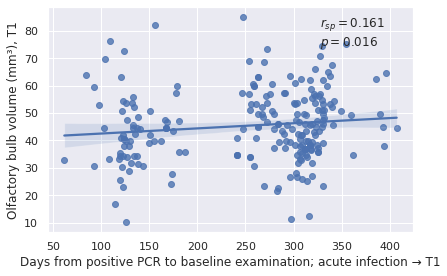

In [52]:
regression_plot(statistics_df,
    x="days_from_pcr_to_examination",
    y="ob_volume_mm3_total",
    covariates=[],
    x_label="Days from positive PCR to baseline examination; acute infection \u2192 T1",
    y_label="Olfactory bulb volume (mm³), T1",
    lm=False,
    output_dir=output_dir/"lm_results",
    bonferroni_factor=None,
    correlation_method="spearman")

# Clinical scores ~ OB volume

In [23]:
neuropsych_variables_formatted = ['Trail Making Test B',
 'Word List Recall',
 'Animal Naming Test',
 'Mini Mental State Exam',
 'PHQ9',
 'EQ5D',
 'GAD7']

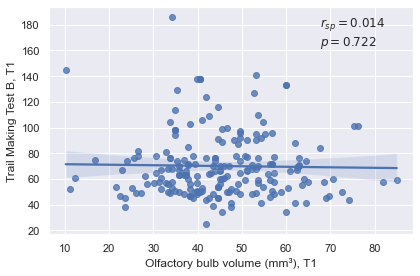

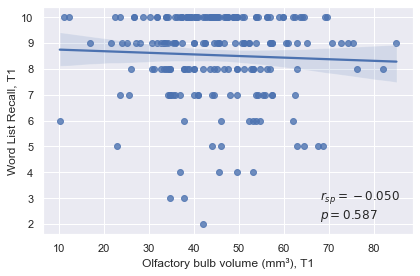

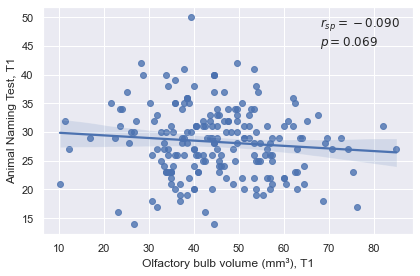

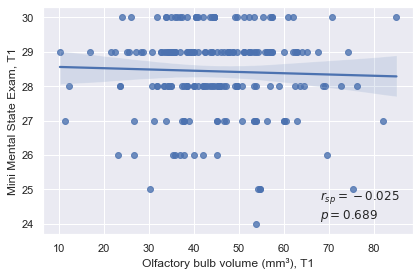

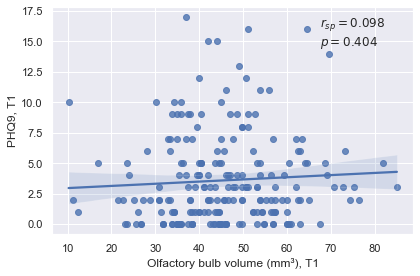

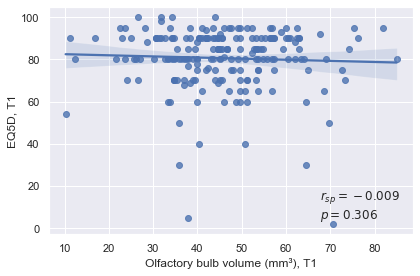

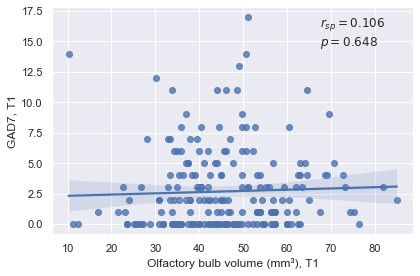

In [24]:
for idx,var in enumerate(neuropsych_variables):
    if idx in [1,3,5]:
        xy=(0.74,0.20)
        regression_plot(statistics_df,
            x="ob_volume_mm3_total",
            y=var,
            covariates=["age","sex","cvrisk_smoking_currently"],
            x_label="Olfactory bulb volume (mm³), T1",
            y_label=f"{neuropsych_variables_formatted[idx]}, T1",
            lm=True,
            output_dir=output_dir/"lm_clinical",
            bonferroni_factor=None,
            correlation_method="spearman",
            annotation_xy=xy)
    else:
        regression_plot(statistics_df,
            x="ob_volume_mm3_total",
            y=var,
            covariates=["age","sex","cvrisk_smoking_currently"],
            x_label="Olfactory bulb volume (mm³), T1",
            y_label=f"{neuropsych_variables_formatted[idx]}, T1",
            lm=True,
            output_dir=output_dir/"lm_clinical",
            bonferroni_factor=None,
            correlation_method="spearman")

# Olfactometry ~ OB volume

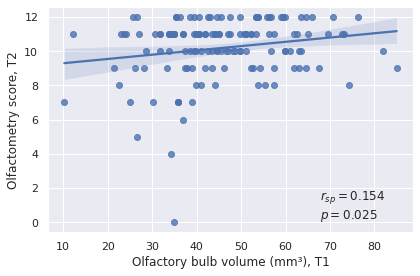

In [62]:
regression_plot(statistics_df,
    x="ob_volume_mm3_total",
    y="olfactometry_postcovid3",
    covariates=["age","sex","cvrisk_smoking_currently"],
    x_label="Olfactory bulb volume (mm³), T1",
    y_label="Olfactometry score, T2",
    lm=True,
    output_dir=output_dir/"lm_results",
    bonferroni_factor=None,
    correlation_method="spearman",
    annotation_xy=(0.74,0.20))

# Boxplot function

In [26]:
statistics_df["sex_numeric"] = statistics_df["sex"].astype(float)
statistics_df["smoking_numeric"] = statistics_df["cvrisk_smoking_currently"].astype(float)

In [29]:
import seaborn as sns
from pingouin import ancova, ttest, mwu
import matplotlib.pyplot as plt

def box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim=None,xticks=None):

    sns.set(style="darkgrid",rc={"figure.figsize":(3, 4)})
    x=data[between]
    y=data[dv]

    plot = sns.boxplot(x=x, y=y, palette="Blues")
    plot.set_ylabel(ylabel)
    plot.set_xlabel(xlabel)
    if xticks: plt.xticks([0,1],xticks)
    else: plt.xticks([0,1],["Normal", "Impaired"])
    
    value1 = data[between].unique()[0]
    value2 = data[between].unique()[1]
    group1_mean, group1_std = data[dv][data[between]==value1].mean(),data[dv][data[between]==value1].std()
    group2_mean, group2_std = data[dv][data[between]==value2].mean(),data[dv][data[between]==value2].std()
    print(f"Group 1 mean: {group1_mean:.2f} +-{group1_std:.2f}")
    print(f"Group 2 mean: {group2_mean:.2f} +-{group2_std:.2f}")
    
    if stat == "ancova":
        stat_df = ancova(data=data, dv=dv, covar=covar, between=between)
        pval, statistic = float(stat_df[stat_df["Source"]==between]["p-unc"]), float(stat_df[stat_df["Source"]==between]["F"])
        statistic_name="f"
    elif stat == "ttest":
        x_observ = data[dv][data[between]==1]
        y_observ = data[dv][data[between]==0]
        stat_df = ttest(x=x_observ,y=y_observ)
        pval, statistic = float(stat_df.loc["T-test","p-val"]), float(stat_df.loc["T-test","T"])
        statistic_name="t"
    elif stat == "mwu":
        x_observ = data[dv][data[between]==1]
        y_observ = data[dv][data[between]==0]
        stat_df = mwu(x=x_observ,y=y_observ)
        pval, statistic = float(stat_df.loc["MWU","p-val"]), float(stat_df.loc["MWU","RBC"])
        statistic_name="RBC"
    else: print(stat, " not available")
    
    if pval < 0.005: pval = "<0.005"
    else: pval = f"{pval:.3f}"
    
    x1,x2 = 0,1
    y,h,col = data[dv].max() + 2,2,"k"

    #plt.annotate(f"cohen's f: {cohen_f:.2f}\n$p$  : {pval}",xy=xy)
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f"${statistic_name}$ : {statistic:.2f}\n$p$ : {pval}", ha='center', va='bottom', color=col)

    minimum = data[dv].min() -10 
    if minimum < 0: minimum = -5
    maximum = data[dv].max() 
    if maximum > 20 : maximum += 20
    if ylim: 
        minimum = ylim[0]
        maximum = ylim[1]
        plot.set_ylim(minimum, maximum)
    else: plot.set_ylim(minimum , maximum)


    filename="boxplot_" + ylabel.replace(" ","_").lower()

    return plot, stat_df, filename

# Group comparison smelling vs. non-smelling at different timepoints

### OB volume

Group 1 mean: 45.85 +-12.92
Group 2 mean: 45.21 +-15.16


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid1,7.298020,1,0.042371,0.837224,0.000314
1,age,686.311140,1,3.984625,0.047929,0.028670
2,sex_numeric,1419.556173,1,8.241743,0.004755,0.057537
3,smoking_numeric,48.573647,1,0.282012,0.596258,0.002085
4,days_pcr_to_mri,31.534696,1,0.183086,0.669416,0.001354
5,Residual,23252.374529,135,NaN,NaN,NaN


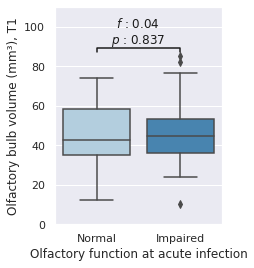

In [31]:
data=statistics_df
stat="ancova"
dv="ob_volume_mm3_total"
between='smelling_postcovid1'
covar=["age","sex_numeric","smoking_numeric", "days_pcr_to_mri"]
xlabel="Olfactory function at acute infection"
ylabel="Olfactory bulb volume (mm³), T1"
ylim=(0,110)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_acute.png", dpi=300, bbox_inches='tight')
stat_df

Group 1 mean: 40.76 +-13.08
Group 2 mean: 46.74 +-13.66


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid2,695.589250,1,4.070398,0.045580,0.028651
1,age,922.549638,1,5.398509,0.021615,0.037647
2,sex_numeric,1054.545712,1,6.170914,0.014183,0.042803
3,smoking_numeric,77.959445,1,0.456197,0.500537,0.003295
4,Residual,23582.781796,138,NaN,NaN,NaN


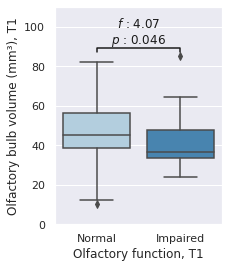

In [34]:
data=statistics_df
stat="ancova"
dv="ob_volume_mm3_total"
between='smelling_postcovid2'
covar=["age","sex_numeric","smoking_numeric"]
xlabel="Olfactory function, T1"
ylabel="Olfactory bulb volume (mm³), T1"
ylim=(0,110)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_tp1.png", dpi=300, bbox_inches='tight')
stat_df

Group 1 mean: 40.45 +-12.59
Group 2 mean: 46.55 +-13.76


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid3,767.136735,1,4.502736,0.035627,0.031598
1,age,1018.275828,1,5.976805,0.015756,0.041512
2,sex_numeric,1078.191932,1,6.328485,0.013028,0.043848
3,smoking_numeric,88.100124,1,0.517107,0.473294,0.003733
4,Residual,23511.234311,138,NaN,NaN,NaN


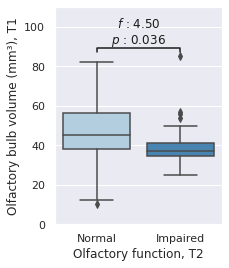

In [35]:
data=statistics_df
stat="ancova"
dv="ob_volume_mm3_total"
between='smelling_postcovid3'
covar=["age","sex_numeric","smoking_numeric"]
xlabel="Olfactory function, T2"
ylabel="Olfactory bulb volume (mm³), T1"
ylim=(0,110)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_tp2.png", dpi=300, bbox_inches='tight')
stat_df

### Olfactometry scores

Group 1 mean: 10.04 +-1.97
Group 2 mean: 10.46 +-1.31


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid1,5.088657,1,1.579467,0.211008,0.011564
1,age,2.959093,1,0.918472,0.339590,0.006758
2,sex_numeric,0.618718,1,0.192044,0.661921,0.001421
3,smoking_numeric,3.538727,1,1.098385,0.296494,0.008071
4,days_pcr_to_mri,0.135490,1,0.042055,0.837824,0.000311
5,Residual,434.936932,135,NaN,NaN,NaN


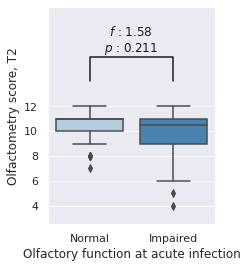

In [36]:
data=statistics_df
stat="ancova"
dv="olfactometry_postcovid3"
between="smelling_postcovid1"
covar=["age","sex_numeric","smoking_numeric", "days_pcr_to_mri"]
xlabel="Olfactory function at acute infection"
ylabel="Olfactometry score, T2"
ylim=(2.5,20)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plot.set_yticks([4,6,8,10,12])
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_acute.png", dpi=300, bbox_inches='tight')
stat_df

Group 1 mean: 8.67 +-2.62
Group 2 mean: 10.58 +-1.22


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid2,85.309059,1,32.835144,6.039080e-08,0.192204
1,age,2.467099,1,0.949577,3.315320e-01,0.006834
2,sex_numeric,0.011169,1,0.004299,9.478193e-01,0.000031
3,smoking_numeric,3.195606,1,1.229977,2.693405e-01,0.008834
4,Residual,358.538105,138,NaN,NaN,NaN


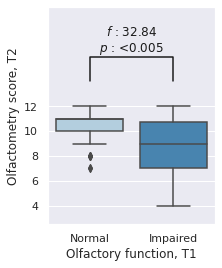

In [37]:
data=statistics_df
stat="ancova"
dv="olfactometry_postcovid3"
between="smelling_postcovid2"
covar=["age","sex_numeric","smoking_numeric"]
xlabel="Olfactory function, T1"
ylabel="Olfactometry score, T2"
ylim=(2.5,20)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plot.set_yticks([4,6,8,10,12])
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_t1.png", dpi=300, bbox_inches='tight')
stat_df

Group 1 mean: 8.40 +-2.74
Group 2 mean: 10.56 +-1.22


,Source,SS,DF,F,p-unc,np2
0,smelling_postcovid3,95.624037,1,37.895579,7.637707e-09,0.215444
1,age,4.517670,1,1.790342,1.830852e-01,0.012807
2,sex_numeric,0.045022,1,0.017842,8.939338e-01,0.000129
3,smoking_numeric,2.506111,1,0.993166,3.207141e-01,0.007145
4,Residual,348.223127,138,NaN,NaN,NaN


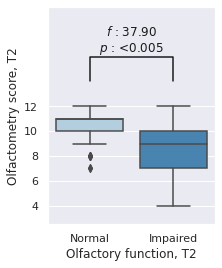

In [38]:
data=statistics_df
stat="ancova"
dv="olfactometry_postcovid3"
between="smelling_postcovid3"
covar=["age","sex_numeric","smoking_numeric"]
xlabel="Olfactory function, T2"
ylabel="Olfactometry score, T2"
ylim=(2.5,20)
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,ylim)
plot.set_yticks([4,6,8,10,12])
plt.savefig(output_dir/f"group_comparison/{filename}_olfactory_function_t2.png", dpi=300, bbox_inches='tight')
stat_df

# OB volumes - recovered vs. non-recovered

Group 1 mean: 40.64 +-12.83
Group 2 mean: 47.58 +-12.56


,Source,SS,DF,F,p-unc,np2
0,smelling_conversion_1to3,886.404205,1,5.855292,0.017518,0.060454
1,age,371.647110,1,2.454978,0.120624,0.026269
2,sex_numeric,571.772014,1,3.776936,0.055054,0.039851
3,smoking_numeric,130.115151,1,0.859498,0.356332,0.009357
4,Residual,13776.046680,91,NaN,NaN,NaN


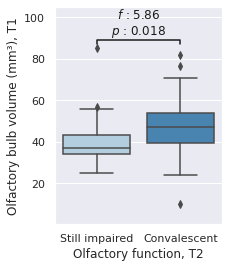

In [45]:
data=statistics_df[statistics_df["smelling_postcovid1"]==1]
stat="ancova"
dv="ob_volume_mm3_total"
between="smelling_conversion_1to3"
covar=["age","sex_numeric","smoking_numeric"]
xlabel="Olfactory function, T2"
ylabel="Olfactory bulb volume (mm³), T1"
xticks=["Still impaired","Convalescent"]
plot,stat_df,filename = box_plot(data,stat,dv,between,covar,xlabel,ylabel,xticks=xticks)
plt.savefig(output_dir/f"group_comparison/{filename}_convalescence1to3.png", dpi=300, bbox_inches='tight')
stat_df

# Longitudinal trajectory of smelling impairment

In [298]:
percentage_smelling_impairment_postcovid1 = statistics_df["smelling_postcovid1"].mean() * 100
percentage_smelling_impairment_postcovid2 = statistics_df["smelling_postcovid2"].mean() * 100
percentage_smelling_impairment_postcovid3 = statistics_df["smelling_postcovid3"].mean() * 100

In [299]:
mean_nas_smelling_postcovid1 = statistics_df["smelling_postcovid1_nas"][statistics_df["smelling_postcovid1"]==1].mean()
std_nas_smelling_postcovid1 = statistics_df["smelling_postcovid1_nas"][statistics_df["smelling_postcovid1"]==1].std()

mean_nas_smelling_postcovid2 = statistics_df["smelling_postcovid2_nas"][statistics_df["smelling_postcovid2"]==1].mean()
std_nas_smelling_postcovid2 = statistics_df["smelling_postcovid2_nas"][statistics_df["smelling_postcovid2"]==1].std()

mean_nas_smelling_postcovid3 = statistics_df["smelling_postcovid3_nas"][statistics_df["smelling_postcovid3"]==1].mean()
std_nas_smelling_postcovid3 = statistics_df["smelling_postcovid3_nas"][statistics_df["smelling_postcovid3"]==1].std()

In [301]:
xlabels = ["Acute infection", "T1", "T2"]

smelling_df = pd.DataFrame({
    "percentage_impairment":
    [percentage_smelling_impairment_postcovid1,
    percentage_smelling_impairment_postcovid2,
    percentage_smelling_impairment_postcovid3],
    "avg_nas":
    [mean_nas_smelling_postcovid1,
    mean_nas_smelling_postcovid2,
    mean_nas_smelling_postcovid3],
    "std_nas":
    [std_nas_smelling_postcovid1,
    std_nas_smelling_postcovid2,
    std_nas_smelling_postcovid3]
}, index=xlabels)

In [302]:
def double_scree_plot(df, var1, var2, xlabel, ylabel1, ylabel2, ax_color_left="darkgray", ax_color_right="darkgray", output_dir=None, plot_significance_hline=None):
    
    # df: dataframe with statistics; pd.DataFrame
    # var1: first variable in df to plot (left y axis); str
    # var2: second variable in df to plot (right y axis); str
    # xlabel: label of x axis; str
    # ylabel1: label of left y axis; str
    # ylabel2: label of right y axis; str
    # ax_color_left: label of left y axis; str
    # ax_color_right: label of right y axis; str
    # output_dir: directory path to save figure to; str or Path
    # plot_significance_hline: plot a horizontal line (e.g., in case of plotting p values for alpha threshold); numeric (that indicates y)  
    # stats: statistical tests to apply to respective columns (length has to match)
    # group_col: columns that differentiates groups


    sns.set_style("darkgrid")

    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(5,4))

    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    #ax_color=axcolor_left
    ax.plot(df.index, df[var1], "o", color=ax_color_left)
    ax.set_xlabel(xlabel, size=12, color="black")
    ax.set_ylabel(ylabel1, size=12,color="black")
    ax.tick_params(axis="y", colors="black")
    ax.spines["top"].set_visible(False)
    ax.set_ylim(-0.1,1)
    ax.set_yticks([25,50,75, 100])
    ax.locator_params(axis="y",nbins=4)

    #ax2_color=axcolor_right
    ax2.plot(df.index, df[var2], "o", color=ax_color_right)
    ax2.set_ylabel(ylabel2, color="black", size=12)
    ax2.spines["right"].set_color(ax_color_right)
    ax2.spines["right"].set_linewidth(3)
    ax2.spines["left"].set_color(ax_color_left)
    ax2.spines["left"].set_linewidth(3)
    ax2.tick_params(axis="y", colors="black", size=2)
    ax2.spines["top"].set_visible(False)
    ax2.set_ylim(-0.1,10)
    #ax2.set_yticks([0.  , 0.4 , 0.8 , 0.05])
    ax2.locator_params(axis="y",nbins=4)

    if plot_significance_hline: plt.axhline(y=plot_significance_hline, color="darkgray", linestyle='dotted')

    plt.tight_layout()

    if output_dir: plt.savefig(f"{output_dir}/{var1}_{var2}_{xlabel}_double_scree_plot.png", dpi=300, bbox_inches='tight')
    
    return fig

In [303]:
smelling_df

,percentage_impairment,avg_nas,std_nas
Acute infection,67.605634,7.621053,2.764436
T1,20.979021,3.793103,1.780436
T2,17.482517,2.958333,2.095112


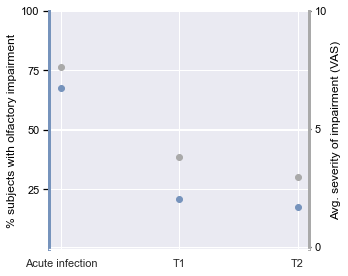

In [304]:
plot = double_scree_plot(
    smelling_df, 
    var1="percentage_impairment", 
    var2="avg_nas", 
    xlabel="", 
    ylabel1="% subjects with olfactory impairment", 
    ylabel2="Avg. severity of impairment (VAS)", 
    ax_color_left="#7693bc", 
    ax_color_right="darkgray", 
    output_dir=output_dir/"olfaction_over_time",
    plot_significance_hline=False)